In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os

In [ ]:
################################'Generate regressor X from an AR(1)'##############################
################################ Xt = α + βXt-1 + εt

T=100;  # sample size
df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y' ])
alpha = 1;    # intercept parameter
beta = 0.9;   # autoregressive parameter
sigma = 0.1;  # standard error of innovations
x1 = alpha/(1-beta) # define initial value for time series x

epsilon = sigma*np.random.randn(T); # generate a vector of T random normal
df.iloc[0,:] = [x1] # initialize x

for i in range(0, T-1):
    df.iloc[i+1,0] = alpha + beta * df.iloc[i,0] + epsilon[i+1] # generate X(t) recursively
    # Xt = α + βXt-1 + εt


In [ ]:
################################'Generate regressor X from an AR(1)'##############################
################################ Xt = α + βXt-1 + εt

def generate_regressor(T, alpha, beta, sigma):
    df = pd.DataFrame(index=range(T), columns=['x', 'epsilon_x'])
    x1 = alpha/(1-beta) # define initial value for time series x
    epsilon = sigma*np.random.randn(T) # generate a vector of T random normal
    
    df.iloc[0,:] = [x1, np.nan] # initialize x
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = alpha + beta * df.iloc[i,0] + epsilon[i+1] # generate X(t) recursively
        df.iloc[i+1,1] = epsilon[i+1] # associate error with X(t)
    
    return df


In [3]:
def generate_data(T, alpha, beta, sigma, alpha_y, beta_y, gamma, theta, sigma_y):
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_x', 'epsilon_y'])
    x1 = alpha/(1-beta) # define initial value for time series x
    y1 = 0
    epsilon_x = sigma*np.random.randn(T) # generate a vector of T random normal
    epsilon_y = sigma_y*np.random.randn(T) # generate a vector of T random normal
    
    df.iloc[0,:] = [x1, y1, np.nan, np.nan] # initialize x and y
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = alpha + beta * df.iloc[i,0] + epsilon_x[i+1] # generate X(t) recursively
            # Xt = α + βXt-1 + εt
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
            # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_x[i+1] # associate error with X(t)
        df.iloc[i+1,3] = epsilon_y[i+1] # associate error with Y(t)
    
    return df


In [11]:
df = generate_data(1000, 1, 0.9, 0.1, 1, 0.9, 0.9, 0.5, 0.1)

In [31]:
def fit_quantile(df, alpha_y, beta_y, gamma):
    # Fit quantile regression at the specified quantile
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    quant_reg_1 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.9)
    # Yt = α + βYt-1 + γXt 

# Plot the quantile regression lines at different quantile levels
    # Create a scatter plot of the data
    plt.scatter(x, y, alpha=0.5)
    x_sort = np.sort(x)
    y_pred_1 = quant_reg_1.predict(x_sort)
    y_pred_5 = quant_reg_5.predict(x_sort)
    y_pred_9 = quant_reg_9.predict(x_sort)

    plt.plot(x_sort, y_pred_1, color='red', label='Quantile level: 0.1')
    plt.plot(x_sort, y_pred_5, color='green', label='Quantile level: 0.5')
    plt.plot(x_sort, y_pred_9, color='blue', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Quantile regression at different quantile levels')
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

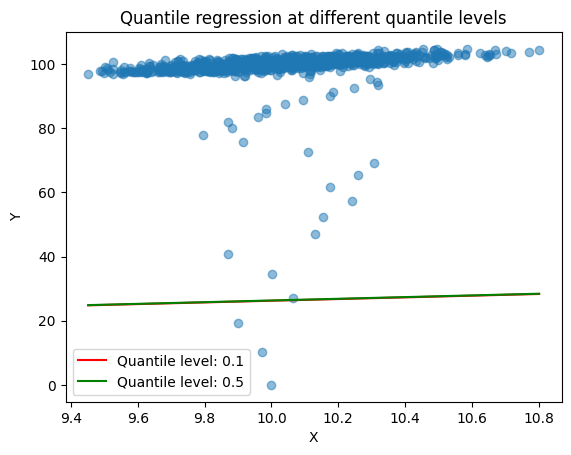

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.8638
 Model:                       QuantReg   Bandwidth:                     0.09314
 Method:                 Least Squares   Sparsity:                        1.255
 Date:                Tue, 18 Apr 2023   No. Observations:                 1000
 Time:                        11:17:42   Df Residuals:                      999
                                         Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1             2.6236      0.000   8473.834      0.000       2.623       2.624
 """,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable

In [32]:
fit_quantile(df, 1, 0.3, 0.7)

In [33]:
################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

#Autocorrelation fades away as the lags increase



AttributeError: 'Summary' object has no attribute 'resid'